# Importing Dataset from Kaggle

In [1]:
! pip install -q kaggle

In [2]:
import os
from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [3]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors


In [4]:
! unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

# Creating Training and Test Sets

In [5]:
# Imports
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import WeightedRandomSampler

In [6]:
# Enable benchmark mode in cuDNN
torch.backends.cudnn.benchmark = True

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(0)
print('Using PyTorch version', torch.__version__)

Using device: cuda
Using PyTorch version 2.6.0+cu124


In [7]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    # Rename original directories
    for idx, dir in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, dir), os.path.join(root_dir, class_names[idx]))

    # Create test directories for each class
    for class_name in class_names:
        os.mkdir(os.path.join(root_dir, 'test', class_name))

    # Move 50 random images per class from images/ subfolder to test set
    for class_name in class_names:
        image_dir = os.path.join(root_dir, class_name, 'images')
        images = [x for x in os.listdir(image_dir) if x.lower().endswith('png')]
        selected_images = random.sample(images, 50)

        for image in selected_images:
            source_path = os.path.join(image_dir, image)
            target_path = os.path.join(root_dir, 'test', class_name, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [8]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        self.images = []
        self.class_names = ['normal', 'viral', 'covid']
        self.transform = transform

        for idx, class_name in enumerate(self.class_names):
            class_dir = image_dirs[class_name]
            if os.path.exists(os.path.join(class_dir, 'images')):  # For training dirs
                class_dir = os.path.join(class_dir, 'images')
            for img in os.listdir(class_dir):
                if img.lower().endswith('png'):
                    self.images.append((os.path.join(class_dir, img), idx))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), label

# Image Transformations

In [9]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [10]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

# Prepare Dataloader

In [11]:
train_dirs = {
    'normal': os.path.join(root_dir, 'normal'),
    'viral': os.path.join(root_dir, 'viral'),
    'covid': os.path.join(root_dir, 'covid')
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

## Adjust Training set for Class Imbalance

In [12]:
# Count the number of samples per class
labels = [label for _, label in train_dataset]
class_sample_counts = np.bincount(labels)

# Compute weights: inverse of frequency
class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
sample_weights = torch.tensor([class_weights[label] for label in labels], dtype=torch.float)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights,
                                 num_samples=len(sample_weights),
                                 replacement=True)

# Update the train dataloader to use the sampler

In [13]:
test_dirs = {
    'normal': os.path.join(root_dir, 'test', 'normal'),
    'viral': os.path.join(root_dir, 'test', 'viral'),
    'covid': os.path.join(root_dir, 'test', 'covid')
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

In [14]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('No. of training batches:', len(dl_train))
print('No. of test batches:', len(dl_test))

No. of training batches: 2501
No. of test batches: 25


# Data Visualization

In [15]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1)
        image = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        color = 'green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i])]}')
        plt.ylabel(f'{class_names[int(preds[i])]}', color=color)
    plt.tight_layout()
    plt.show()

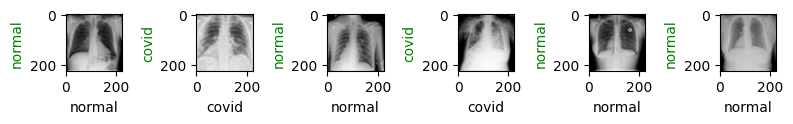

In [16]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

# Creating the Model

In [17]:
# Load pretrained model and update final layer
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
resnet18 = resnet18.to(device)

# Normalize weights
normalized_weights = class_weights / class_weights.sum()
normalized_weights = normalized_weights.to(device)

# Weighted loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=normalized_weights)

optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

## Print the Class Weights

In [19]:
print("Class sample counts:", class_sample_counts.tolist())
print("Normalized class weights:", normalized_weights.tolist())

Class sample counts: [10142, 1295, 3566]
Normalized class weights: [0.08564765006303787, 0.6707633137702942, 0.24358904361724854]


In [20]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

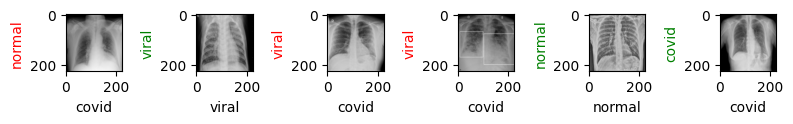

In [21]:
show_preds()

# Train the model

In [22]:
def train(epochs):
    print('Starting training...')
    for e in range(epochs):
        print('=' * 20)
        print(f'Epoch {e + 1}/{epochs}')
        print('=' * 20)

        resnet18.train()
        train_loss = 0

        for train_step, (images, labels) in enumerate(dl_train):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                resnet18.eval()
                val_loss, acc = 0.0, 0.0
                with torch.no_grad():
                    for val_step, (images, labels) in enumerate(dl_test):
                        images, labels = images.to(device), labels.to(device)
                        outputs = resnet18(images)
                        loss = loss_fn(outputs, labels)
                        val_loss += loss.item()
                        _, preds = torch.max(outputs, 1)
                        acc += (preds == labels).sum().item()
                val_loss /= (val_step + 1)
                acc /= len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Accuracy: {acc:.4f}')
                show_preds()

                if acc > 0.95:
                    saved_weights_name = "resnet18_covid.pth"
                    print('Performance condition satisfied...')
                    torch.save(resnet18.state_dict(), saved_weights_name)
                    print(f"Model weights saved at {saved_weights_name}!")
                    return

                resnet18.train()

        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')

# Train and Evaluate

Starting training...
Epoch 1/5
Evaluating at step 0
Val loss: 1.0393, Accuracy: 0.3267


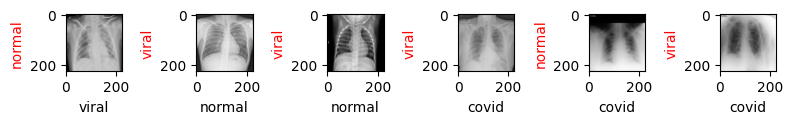

Evaluating at step 20
Val loss: 0.6159, Accuracy: 0.5467


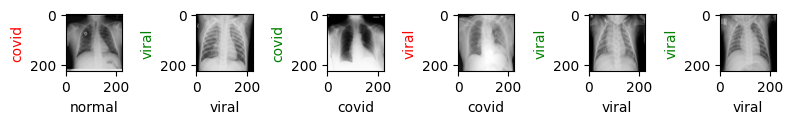

Evaluating at step 40
Val loss: 0.3785, Accuracy: 0.7067


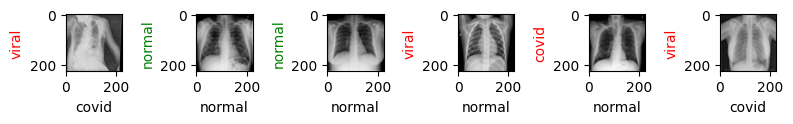

Evaluating at step 60
Val loss: 0.2873, Accuracy: 0.8000


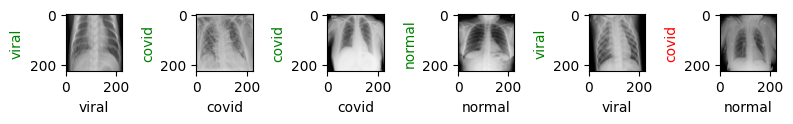

Evaluating at step 80
Val loss: 0.2277, Accuracy: 0.8067


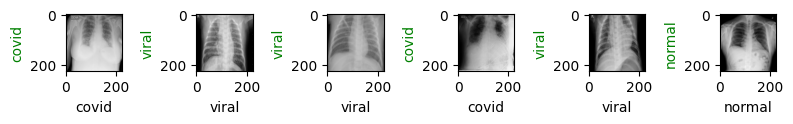

Evaluating at step 100
Val loss: 0.1910, Accuracy: 0.8133


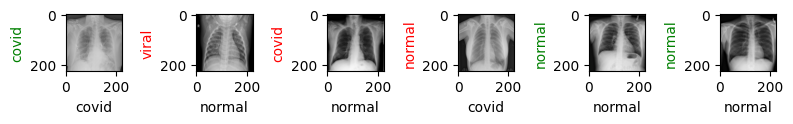

Evaluating at step 120
Val loss: 0.1695, Accuracy: 0.8267


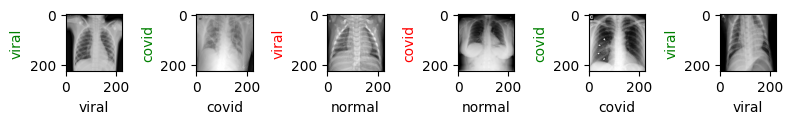

Evaluating at step 140
Val loss: 0.1814, Accuracy: 0.8200


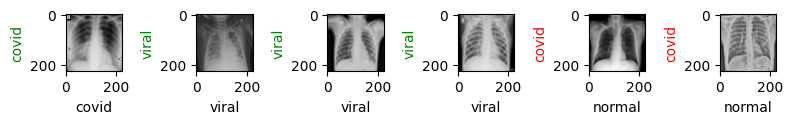

Evaluating at step 160
Val loss: 0.1453, Accuracy: 0.8400


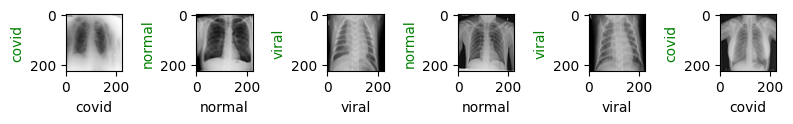

Evaluating at step 180
Val loss: 0.1336, Accuracy: 0.8733


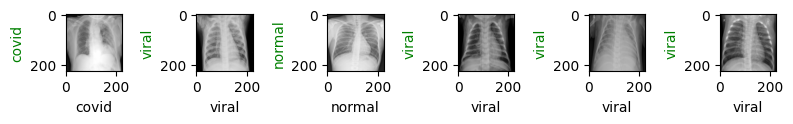

Evaluating at step 200
Val loss: 0.1193, Accuracy: 0.8800


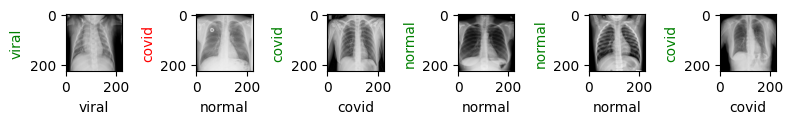

Evaluating at step 220
Val loss: 0.1290, Accuracy: 0.8733


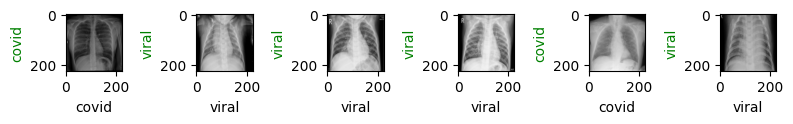

Evaluating at step 240
Val loss: 0.1237, Accuracy: 0.8867


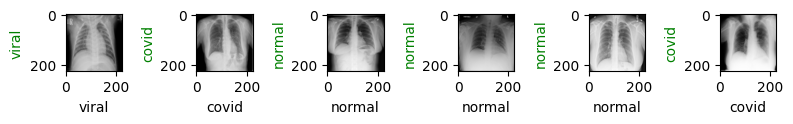

Evaluating at step 260
Val loss: 0.1699, Accuracy: 0.7867


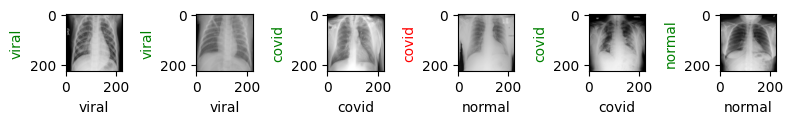

Evaluating at step 280
Val loss: 0.1085, Accuracy: 0.9067


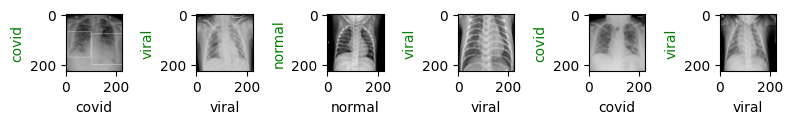

Evaluating at step 300
Val loss: 0.1046, Accuracy: 0.9133


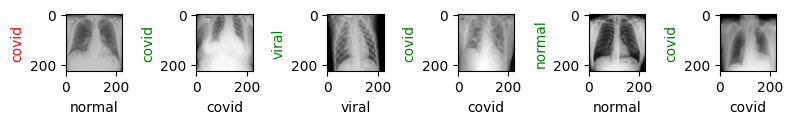

Evaluating at step 320
Val loss: 0.1021, Accuracy: 0.9133


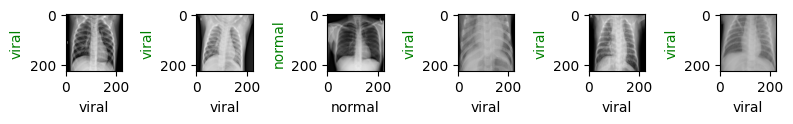

Evaluating at step 340
Val loss: 0.1204, Accuracy: 0.9133


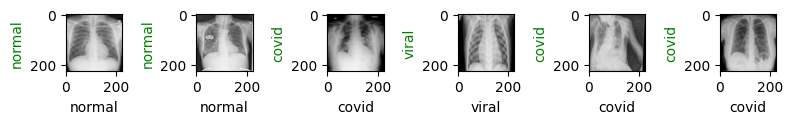

Evaluating at step 360
Val loss: 0.1242, Accuracy: 0.9200


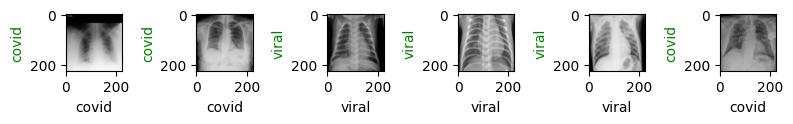

Evaluating at step 380
Val loss: 0.1125, Accuracy: 0.8933


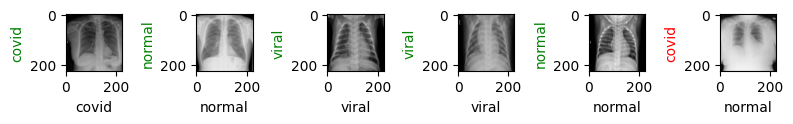

Evaluating at step 400
Val loss: 0.0853, Accuracy: 0.9200


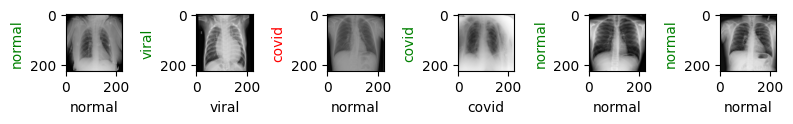

Evaluating at step 420
Val loss: 0.0999, Accuracy: 0.9267


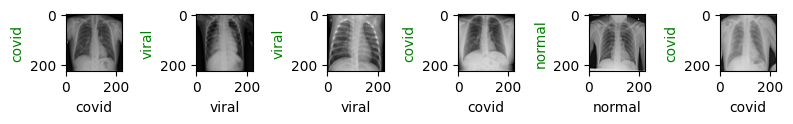

Evaluating at step 440
Val loss: 0.1068, Accuracy: 0.8933


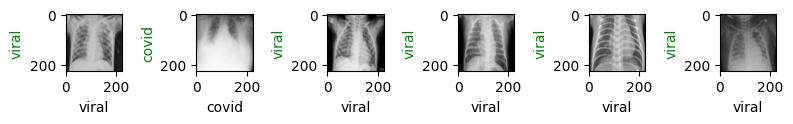

Evaluating at step 460
Val loss: 0.0879, Accuracy: 0.8933


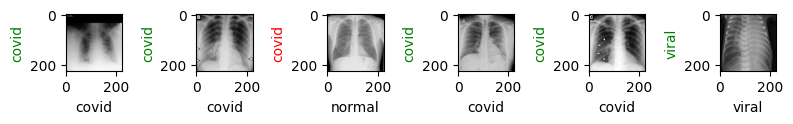

Evaluating at step 480
Val loss: 0.0866, Accuracy: 0.8933


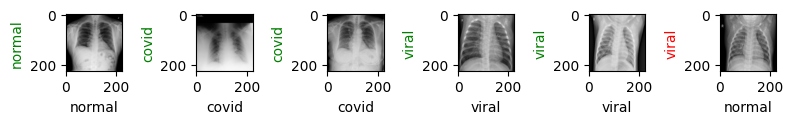

Evaluating at step 500
Val loss: 0.1138, Accuracy: 0.8667


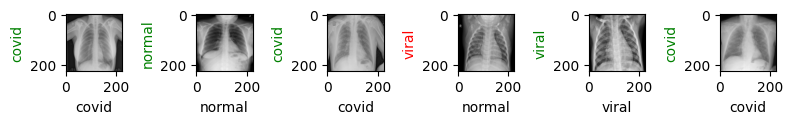

Evaluating at step 520
Val loss: 0.0854, Accuracy: 0.9200


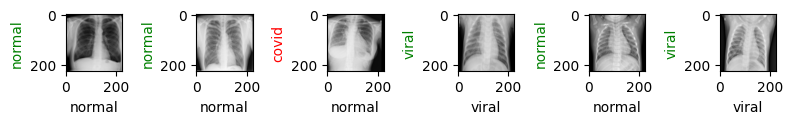

Evaluating at step 540
Val loss: 0.1042, Accuracy: 0.9000


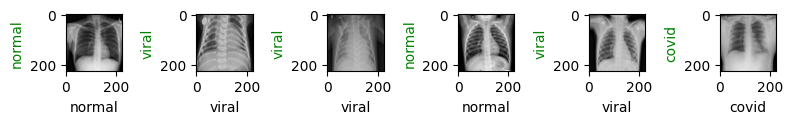

Evaluating at step 560
Val loss: 0.1047, Accuracy: 0.9000


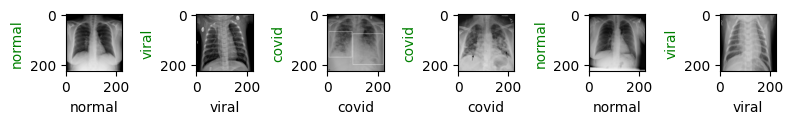

Evaluating at step 580
Val loss: 0.0824, Accuracy: 0.9133


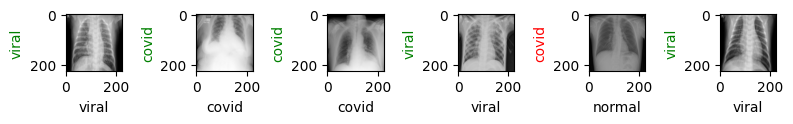

Evaluating at step 600
Val loss: 0.0823, Accuracy: 0.9133


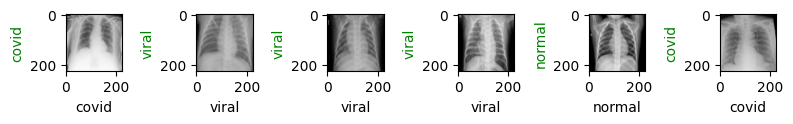

Evaluating at step 620
Val loss: 0.0890, Accuracy: 0.9533


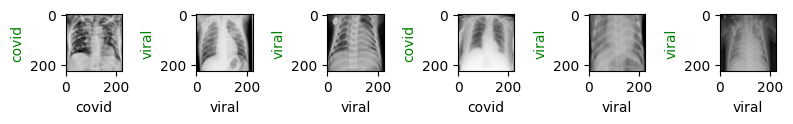

Performance condition satisfied...
Model weights saved at resnet18_covid.pth!


In [23]:
train(epochs=5)

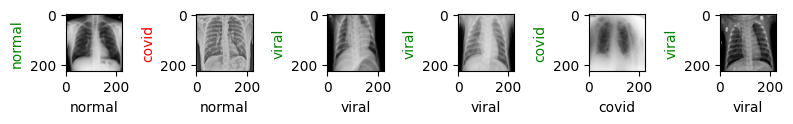

In [24]:
show_preds()

# Final Accuracy Evaluation

In [25]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    # Track per-class accuracy
    num_classes = len(class_names)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Per-class accuracy update
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

    overall_accuracy = correct / total
    print(f'\n✅ Final Test Accuracy: {overall_accuracy * 100:.2f}%')

    print("\n📊 Class-wise Accuracy Breakdown:")
    for i in range(num_classes):
        if class_total[i] > 0:
            acc = 100.0 * class_correct[i] / class_total[i]
            print(f"  {class_names[i]:<10}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")
        else:
            print(f"  {class_names[i]:<10}: No samples found")

In [26]:
evaluate_accuracy(resnet18, dl_test)


✅ Final Test Accuracy: 95.33%

📊 Class-wise Accuracy Breakdown:
  normal    : 94.00% (47/50)
  viral     : 98.00% (49/50)
  covid     : 94.00% (47/50)
